In [8]:
# === Cell 1: Upload files in Colab ===
from google.colab import files
print("➡️ Click 'Choose Files' and upload: train_large_linear_regression.txt and ex1data1.txt (optional).")
uploaded = files.upload()
print("Uploaded:", list(uploaded.keys()))


➡️ Click 'Choose Files' and upload: train_large_linear_regression.txt and ex1data1.txt (optional).


Saving ex1data1.txt to ex1data1.txt
Saving train_large_linear_regression.txt to train_large_linear_regression.txt
Uploaded: ['ex1data1.txt', 'train_large_linear_regression.txt']


Training data: train_large_linear_regression.txt
Test data    : ex1data1.txt

=== Learning-Rate Comparison ===
 learning_rate  final_loss  epochs_to_within_5pct_of_final  instability_upward_jumps  diverged
         0.001  536.508667                            2886                         0     False
         0.010    3.295583                             803                         0     False
         0.100    3.295583                              81                         0     False


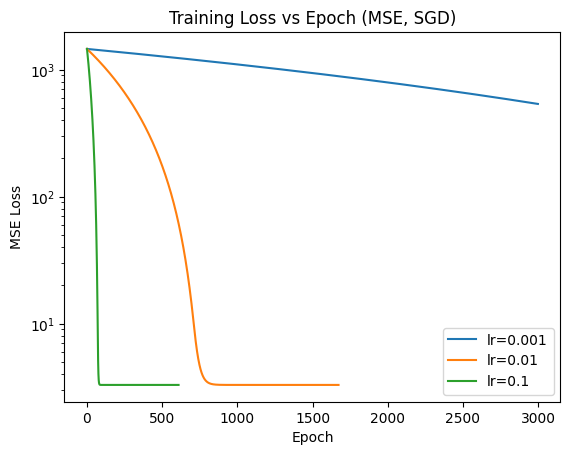

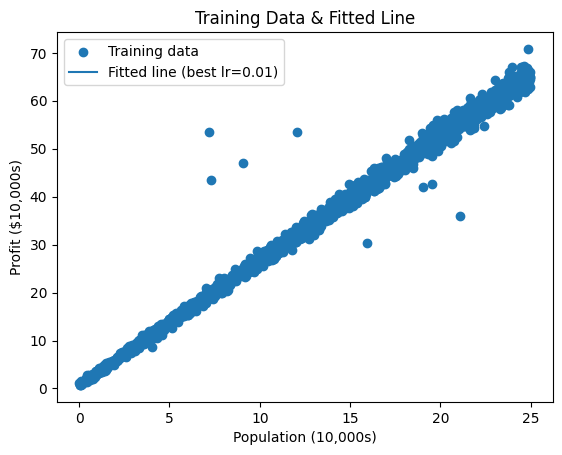

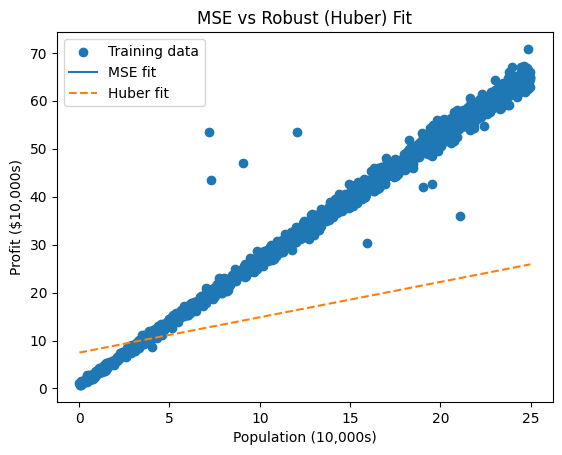


Test MSE (best MSE model on test file): 300.9172 (in $10,000s^2)
K-fold CV MSE (K=5) on training file: mean=3.3041, std=3.6650

=== CEO Forecast (MSE model) ===
Point estimate for 80,000 population: $216,439
95% Confidence Interval (average city at 80k): $215,358 to $217,520
95% Prediction Interval (one new city):       $180,790 to $252,089

Bootstrap (non-parametric) for the same prediction:
Median predicted profit: $216,416
Approx. 95% bootstrap interval: $215,566 to $217,616

=== Executive Summary ===
- Best learning rate here: 0.01 (fastest stable convergence; see loss curves).
- MSE best-fit line: y = 2.5899 * x + 0.9250 (x in 10,000s; y in $10,000s).
- Test MSE: 300.917  |  K-fold (train CV) mean±sd: 3.304 ± 3.665
- Robust (Huber) fit: y = 0.7366 * x + 7.4860  (compare the two lines for outlier sensitivity).
- Use the prediction interval to budget for a single new city; it reflects real city-to-city variability.


In [12]:
# Linear Regression (PyTorch) — CEO-ready analysis pack
# - Files:
#     * train_large_linear_regression.txt  (preferred for training)
#     * ex1data1.txt                       (preferred for testing)
#   If missing, you'll be prompted to upload in Colab, else a tiny fallback sample is used.
#
# What you get:
#   1) Learning-rate experiments with stability diagnostics (0.001, 0.01, 0.1 by default)
#   2) Loss curves (with log-scale option) and a training scatter + fitted line
#   3) Prediction for x=8 (80,000 people) with 95% CI (mean) and 95% PI (new city) in $ units
#   4) Optional bootstrap CI/PI for the same prediction
#   5) Robust fit (Huber loss) line for outlier sensitivity check
#   6) Optional K-fold CV on the training set (generalization probe)
#
# Author notes:
#   - Intervals use classical simple-linear-regression formulas (no extra libs).
#   - Training runs in standardized x-space for numerical stability; outputs back-converted.
#   - Robust fit uses torch.nn.HuberLoss (delta=1.0).
#
# ------------------------------------------------------------

import os, math, sys, io, random
from typing import Dict, Tuple, List
import numpy as np
import matplotlib.pyplot as plt

import torch


def load_datasets() -> Tuple[np.ndarray, np.ndarray, str, np.ndarray, np.ndarray, str]:
    train_path = "train_large_linear_regression.txt" if os.path.exists("train_large_linear_regression.txt") else None
    test_path  = "ex1data1.txt" if os.path.exists("ex1data1.txt") else None

    if train_path is None and test_path is None:
        maybe_upload()
        train_path = "train_large_linear_regression.txt" if os.path.exists("train_large_linear_regression.txt") else None
        test_path  = "ex1data1.txt" if os.path.exists("ex1data1.txt") else None

    if train_path is None and test_path is not None:
        # train on ex1 if train_large missing
        train_path = test_path

    A = _try_load(train_path)
    x_train, y_train = A[:,0:1], A[:,1:2]
    B = None
    if test_path is not None:
        B = _try_load(test_path)
        x_test, y_test = B[:,0:1], B[:,1:2]
        test_src = test_path
    else:
        x_test, y_test = x_train.copy(), y_train.copy()
        test_src = "(same as training—no separate test)"
    return x_train, y_train, train_path, x_test, y_test, test_src

x_train, y_train, train_src, x_test, y_test, test_src = load_datasets()
print("Training data:", train_src)
print("Test data    :", test_src)
assert x_train.shape[1] == 1 and y_train.shape[1] == 1, "Expected 2 columns: population, profit."

# Clean NaNs/inf just in case
def clean_xy(x, y):
    m = np.isfinite(x[:,0]) & np.isfinite(y[:,0])
    return x[m], y[m]
x_train, y_train = clean_xy(x_train, y_train)
x_test,  y_test  = clean_xy(x_test,  y_test)

# ---------- Standardization of x for training (convert back later) ----------
def standardize_x(x):
    mu = float(x.mean())
    sd = float(x.std(ddof=0))
    if sd == 0: sd = 1.0
    return (x - mu)/sd, mu, sd

x_tr_std, x_mu, x_sd = standardize_x(x_train)
x_te_std = (x_test - x_mu)/x_sd

def unstandardize_wb(w_std: float, b_std: float, mu: float, sd: float) -> Tuple[float,float]:
    # y = w_std*(x-μ)/σ + b_std  -> y = (w_std/σ)*x + (b_std - w_std*μ/σ)
    w = w_std / sd
    b = b_std - (w_std * mu / sd)
    return float(w), float(b)

# ---------- Training with safety rails ----------
def train_linear_sgd(x_std: np.ndarray, y: np.ndarray, lr=0.01, epochs=1200,
                     clip_norm=5.0, seed=42, early_stopping_patience=200) -> Dict:
    torch.manual_seed(seed)
    x = torch.tensor(x_std, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    w = torch.randn(1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    opt = torch.optim.SGD([w, b], lr=lr)
    loss_mse = torch.nn.MSELoss()

    best_loss = float("inf")
    best_state = None
    epochs_no_improve = 0
    losses = []
    diverged = False

    for ep in range(epochs):
        y_pred = w * x + b
        loss = loss_mse(y_pred, y_t)

        if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 1e20:
            diverged = True
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_([w, b], max_norm=clip_norm)
        opt.step(); opt.zero_grad()
        L = float(loss.item())
        losses.append(L)

        # early stopping on smoothed best
        if L + 1e-9 < best_loss:
            best_loss = L
            best_state = (float(w.detach()), float(b.detach()))
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                break

    if best_state is None:
        best_state = (float(w.detach()), float(b.detach()))
    return {
        "w_std": best_state[0],
        "b_std": best_state[1],
        "losses": losses,
        "diverged": diverged
    }

def epochs_to_within_pct(losses: List[float], pct=5.0) -> int:
    if not losses: return 0
    final = losses[-1]
    if not np.isfinite(final): return len(losses)
    threshold = (1 + pct/100.0) * final
    for i, L in enumerate(losses, 1):
        if L <= threshold:
            return i
    return len(losses)

def instability_jumps(losses: List[float], rel=0.01) -> int:
    ups = 0
    for i in range(1, len(losses)):
        if losses[i] > (1+rel)*losses[i-1]:
            ups += 1
    return ups

# ---------- Experiment: multiple learning rates ----------
LEARNING_RATES = (0.001, 0.01, 0.1)
results = {}
for lr in LEARNING_RATES:
    out = train_linear_sgd(x_tr_std, y_train, lr=lr, epochs=3000, clip_norm=5.0, seed=42, early_stopping_patience=500)
    w, b = unstandardize_wb(out["w_std"], out["b_std"], x_mu, x_sd)
    out.update({"w": w, "b": b, "lr": lr})
    results[lr] = out

# pick best (lowest finite final loss)
def final_loss_safe(losses):
    return losses[-1] if losses and np.isfinite(losses[-1]) else float("inf")
best_lr = min(LEARNING_RATES, key=lambda lr: final_loss_safe(results[lr]["losses"]))
best = results[best_lr]

# ---------- Diagnostics table ----------
import pandas as pd
rows = []
for lr in LEARNING_RATES:
    r = results[lr]
    lfin = final_loss_safe(r["losses"])
    rows.append({
        "learning_rate": lr,
        "final_loss": lfin,
        "epochs_to_within_5pct_of_final": epochs_to_within_pct(r["losses"], 5.0),
        "instability_upward_jumps": instability_jumps(r["losses"]),
        "diverged": r["diverged"]
    })
summary_df = pd.DataFrame(rows).sort_values("learning_rate")
print("\n=== Learning-Rate Comparison ===")
print(summary_df.to_string(index=False))

# ---------- Plots ----------
def plot_losses(results: Dict[float,Dict], logy=True):
    plt.figure()
    for lr, r in results.items():
        plt.plot(r["losses"], label=f"lr={lr}")
    plt.title("Training Loss vs Epoch (MSE, SGD)")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    if logy: plt.yscale("log")
    plt.legend(); plt.show()

def plot_fit(x, y, w, b, label=f"Fitted line"):
    plt.figure()
    plt.scatter(x, y, label="Training data")
    xs = np.linspace(float(x.min()), float(x.max()), 200)
    ys = w*xs + b
    plt.plot(xs, ys, label=label)
    plt.title("Training Data & Fitted Line")
    plt.xlabel("Population (10,000s)")
    plt.ylabel("Profit ($10,000s)")
    plt.legend(); plt.show()

plot_losses(results, logy=True)
plot_fit(x_train, y_train, best["w"], best["b"], label=f"Fitted line (best lr={best_lr})")

# ---------- Closed-form uncertainty for prediction at x0 ----------
def ci_pi_at_x0(x, y, w, b, x0, alpha=0.05):
    # Classical simple-linear formulas (with intercept):
    # s^2 = SSE/(n-2); Sxx = sum((x - xbar)^2)
    x = x.squeeze().astype(float)
    y = y.squeeze().astype(float)
    yhat = w*x + b
    n = x.shape[0]
    xbar = float(x.mean())
    Sxx = float(((x - xbar)**2).sum())
    SSE = float(((y - yhat)**2).sum())
    dof = max(n-2, 1)
    s2 = SSE / dof
    s = math.sqrt(s2)
    # t critical
    try:
        from scipy.stats import t
        tcrit = float(t.ppf(1 - alpha/2.0, df=dof))
    except Exception:
        tcrit = 1.96  # normal approx

    y0 = w*x0 + b
    se_mean = s * math.sqrt(1.0/n + (x0 - xbar)**2 / max(Sxx, 1e-12))  # CI around mean
    se_pred = s * math.sqrt(1.0 + 1.0/n + (x0 - xbar)**2 / max(Sxx, 1e-12))  # PI for new obs
    ci = (y0 - tcrit*se_mean, y0 + tcrit*se_mean)
    pi = (y0 - tcrit*se_pred, y0 + tcrit*se_pred)
    return y0, ci, pi, s, Sxx, SSE, dof

# ---------- Optional bootstrap for prediction at x0 ----------
def bootstrap_pred(x, y, x0, B=1000, seed=123):
    rng = np.random.default_rng(seed)
    n = x.shape[0]
    preds = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        xb, yb = x[idx], y[idx]
        # Fit OLS in closed form for speed: [1, x] beta = y
        X = np.column_stack([np.ones_like(xb), xb])
        beta = np.linalg.pinv(X).dot(yb)  # (b, w)
        b, w = float(beta[0]), float(beta[1])
        preds.append(w*x0 + b)
    preds = np.array(preds, dtype=float).squeeze()
    return float(np.median(preds)), (float(np.percentile(preds, 2.5)), float(np.percentile(preds, 97.5)))

# ---------- Robust fit with Huber loss (less sensitive to outliers) ----------
def train_huber(x_std, y, lr=0.01, epochs=2000, delta=1.0, clip_norm=5.0, seed=42):
    torch.manual_seed(seed)
    x = torch.tensor(x_std, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    w = torch.randn(1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    opt = torch.optim.SGD([w, b], lr=lr)
    loss_huber = torch.nn.HuberLoss(delta=delta)

    for ep in range(epochs):
        y_pred = w*x + b
        loss = loss_huber(y_pred, y_t)
        if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 1e20:
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_([w, b], max_norm=clip_norm)
        opt.step(); opt.zero_grad()
    return unstandardize_wb(float(w.detach()), float(b.detach()), x_mu, x_sd)

w_best, b_best = best["w"], best["b"]
w_hub, b_hub   = train_huber(x_tr_std, y_train, lr=best_lr if not results[0.1]["diverged"] else 0.01)

# plot robust vs mse
def plot_fit_two(x, y, wb1, wb2, labels=("MSE fit","Huber fit")):
    w1,b1 = wb1; w2,b2 = wb2
    plt.figure()
    plt.scatter(x, y, label="Training data")
    xs = np.linspace(float(x.min()), float(x.max()), 200)
    plt.plot(xs, w1*xs + b1, label=labels[0])
    plt.plot(xs, w2*xs + b2, label=labels[1], linestyle="--")
    plt.title("MSE vs Robust (Huber) Fit")
    plt.xlabel("Population (10,000s)"); plt.ylabel("Profit ($10,000s)")
    plt.legend(); plt.show()

plot_fit_two(x_train, y_train, (w_best,b_best), (w_hub,b_hub))

# ---------- Generalization probe: test error & optional K-fold ----------
def mse_of_line(x, y, w, b):
    yhat = w*x + b
    return float(np.mean((yhat - y)**2))

test_mse = mse_of_line(x_test, y_test, w_best, b_best)
print(f"\nTest MSE (best MSE model on test file): {test_mse:.4f} (in $10,000s^2)")

def kfold_cv(x, y, K=5, seed=123, lr=0.01, epochs=1500):
    rng = np.random.default_rng(seed)
    n = x.shape[0]
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, K)
    mses = []
    for k in range(K):
        te_idx = folds[k]
        tr_idx = np.concatenate([folds[i] for i in range(K) if i != k])
        xtr, ytr = x[tr_idx], y[tr_idx]
        xte, yte = x[te_idx], y[te_idx]
        xtr_std, mu, sd = standardize_x(xtr)
        out = train_linear_sgd(xtr_std, ytr, lr=lr, epochs=epochs, early_stopping_patience=400)
        w, b = unstandardize_wb(out["w_std"], out["b_std"], mu, sd)
        mses.append(mse_of_line(xte, yte, w, b))
    return float(np.mean(mses)), float(np.std(mses, ddof=1)) if K>1 else 0.0

if x_train.shape[0] >= 10:
    cv_mean, cv_std = kfold_cv(x_train, y_train, K=5, lr=best_lr)
    print(f"K-fold CV MSE (K=5) on training file: mean={cv_mean:.4f}, std={cv_std:.4f}")
else:
    print("K-fold CV skipped (too few rows).")

# ---------- CEO-facing forecast for x0=8 (80k population) ----------
x0 = 8.0
y0, ci, pi, s, Sxx, SSE, dof = ci_pi_at_x0(x_train, y_train, w_best, b_best, x0, alpha=0.05)

# Money units (data are in $10,000s)
to_usd = lambda v: float(v)*10000.0
fmt = lambda v: "${:,.0f}".format(v)

print("\n=== CEO Forecast (MSE model) ===")
print(f"Point estimate for 80,000 population: {fmt(to_usd(y0))}")
print(f"95% Confidence Interval (average city at 80k): {fmt(to_usd(ci[0]))} to {fmt(to_usd(ci[1]))}")
print(f"95% Prediction Interval (one new city):       {fmt(to_usd(pi[0]))} to {fmt(to_usd(pi[1]))}")

# Bootstrap (optional; comment out to speed up)
if x_train.shape[0] >= 10:
    med_b, ci_boot = bootstrap_pred(x_train.squeeze(), y_train.squeeze(), x0, B=1000, seed=7)
    print("\nBootstrap (non-parametric) for the same prediction:")
    print(f"Median predicted profit: {fmt(to_usd(med_b))}")
    print(f"Approx. 95% bootstrap interval: {fmt(to_usd(ci_boot[0]))} to {fmt(to_usd(ci_boot[1]))}")

# Quick executive summary
print("\n=== Executive Summary ===")
print(f"- Best learning rate here: {best_lr} (fastest stable convergence; see loss curves).")
print(f"- MSE best-fit line: y = {w_best:.4f} * x + {b_best:.4f} (x in 10,000s; y in $10,000s).")
print(f"- Test MSE: {test_mse:.3f}  |  K-fold (train CV) mean±sd: {cv_mean:.3f} ± {cv_std:.3f}" if x_train.shape[0] >= 10 else "- CV skipped.")
print(f"- Robust (Huber) fit: y = {w_hub:.4f} * x + {b_hub:.4f}  (compare the two lines for outlier sensitivity).")
print("- Use the prediction interval to budget for a single new city; it reflects real city-to-city variability.")


Model (y in $10,000s, x in 10,000s):  y = 2.5899 * x + 0.9250
Train MSE: 3.2956 | Train R^2: 0.991
Test  MSE: 300.9172 | Test  R^2: -9.014
Diagnosis: Overfitting (test error >> train error)
Train/Test MSE ratio: 91.309
Train x-range: [0.013, 24.986] | Test x-range: [5.027, 22.203]


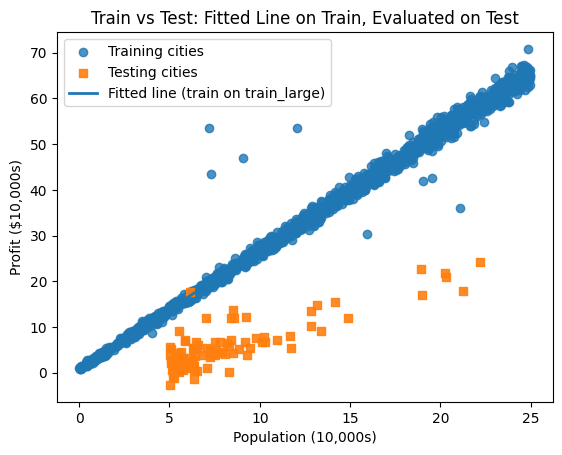

In [10]:
import os, math
import numpy as np
import matplotlib.pyplot as plt
import torch

# ----------------- Helpers -----------------
def load_2col(path):
    try:
        arr = np.loadtxt(path, delimiter=",", dtype=np.float64)
        if arr.ndim == 1: arr = arr.reshape(-1, 2)
        return arr
    except Exception:
        arr = np.loadtxt(path, dtype=np.float64)
        if arr.ndim == 1: arr = arr.reshape(-1, 2)
        return arr

def standardize_x(x):
    mu = float(x.mean()); sd = float(x.std(ddof=0))
    if sd == 0: sd = 1.0
    return (x - mu)/sd, mu, sd

def unstandardize_wb(w_std, b_std, mu, sd):
    # y = w_std*(x - mu)/sd + b_std  =>  y = (w_std/sd)*x + (b_std - w_std*mu/sd)
    w = w_std / sd
    b = b_std - (w_std * mu / sd)
    return float(w), float(b)

def train_sgd(x_std, y, lr=0.01, epochs=3000, clip=5.0, patience=500, seed=42):
    torch.manual_seed(seed)
    x = torch.tensor(x_std, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    w = torch.randn(1, requires_grad=True); b = torch.zeros(1, requires_grad=True)
    opt = torch.optim.SGD([w, b], lr=lr)
    mse = torch.nn.MSELoss()
    best = (float("inf"), float(w.detach()), float(b.detach()))
    no_improve = 0
    losses = []
    for ep in range(epochs):
        y_pred = w*x + b
        loss = mse(y_pred, y_t)
        if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 1e20:
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_([w, b], max_norm=clip)
        opt.step(); opt.zero_grad()
        L = float(loss.item()); losses.append(L)
        if L < best[0] - 1e-9:
            best = (L, float(w.detach()), float(b.detach()))
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break
    return {"w_std": best[1], "b_std": best[2], "losses": losses}

def mse_of_line(x, y, w, b):
    return float(np.mean((w*x + b - y)**2))

def r2_of_line(x, y, w, b):
    yhat = w*x + b
    ss_res = float(np.sum((y - yhat)**2))
    ss_tot = float(np.sum((y - float(np.mean(y)))**2))
    return 1.0 - ss_res/max(ss_tot, 1e-12)

# ----------------- Load data -----------------
train_path = "train_large_linear_regression.txt"
test_path  = "ex1data1.txt"
assert os.path.exists(train_path), "Missing train_large_linear_regression.txt"
assert os.path.exists(test_path), "Missing ex1data1.txt"

train = load_2col(train_path); test = load_2col(test_path)
x_tr, y_tr = train[:,0:1], train[:,1:2]
x_te, y_te = test[:,0:1],  test[:,1:2]

# Clean any bad rows
good_tr = np.isfinite(x_tr[:,0]) & np.isfinite(y_tr[:,0])
good_te = np.isfinite(x_te[:,0]) & np.isfinite(y_te[:,0])
x_tr, y_tr = x_tr[good_tr], y_tr[good_tr]
x_te, y_te = x_te[good_te], y_te[good_te]

# ----------------- Train on standardized x -----------------
x_tr_std, x_mu, x_sd = standardize_x(x_tr)
res = train_sgd(x_tr_std, y_tr, lr=0.01, epochs=3000, clip=5.0, patience=500)
w, b = unstandardize_wb(res["w_std"], res["b_std"], x_mu, x_sd)

# ----------------- Errors & R^2 -----------------
train_mse = mse_of_line(x_tr, y_tr, w, b)
test_mse  = mse_of_line(x_te, y_te, w, b)
train_r2  = r2_of_line(x_tr, y_tr, w, b)
test_r2   = r2_of_line(x_te, y_te, w, b)

print("Model (y in $10,000s, x in 10,000s):  y = {:.4f} * x + {:.4f}".format(w, b))
print("Train MSE: {:.4f} | Train R^2: {:.3f}".format(train_mse, train_r2))
print("Test  MSE: {:.4f} | Test  R^2: {:.3f}".format(test_mse,  test_r2))

# ----------------- Simple diagnosis -----------------
ratio = test_mse / max(train_mse, 1e-12)
if train_r2 < 0.2 and test_r2 < 0.2:
    diagnosis = "Underfitting (both errors high / low R²)"
elif ratio > 1.5 and test_r2 + 0.05 < train_r2:
    diagnosis = "Overfitting (test error >> train error)"
else:
    diagnosis = "Good fit (train ≈ test and both reasonable)"

print("Diagnosis:", diagnosis)
print("Train/Test MSE ratio:", round(ratio, 3))

# ----------------- Distribution / range check -----------------
train_min, train_max = float(x_tr.min()), float(x_tr.max())
test_min,  test_max  = float(x_te.min()), float(x_te.max())
print("Train x-range: [{:.3f}, {:.3f}] | Test x-range: [{:.3f}, {:.3f}]".format(
    train_min, train_max, test_min, test_max))
if test_min < train_min - 1e-9 or test_max > train_max + 1e-9:
    print("⚠️  Warning: test contains populations outside the training range (extrapolation).")

# ----------------- Plot: training vs testing + fitted line -----------------
plt.figure()
plt.scatter(x_tr, y_tr, label="Training cities", alpha=0.8, marker="o")
plt.scatter(x_te, y_te, label="Testing cities",  alpha=0.9, marker="s")
xs = np.linspace(min(train_min, test_min), max(train_max, test_max), 200)
ys = w*xs + b
plt.plot(xs, ys, label="Fitted line (train on train_large)", linewidth=2)
plt.title("Train vs Test: Fitted Line on Train, Evaluated on Test")
plt.xlabel("Population (10,000s)")
plt.ylabel("Profit ($10,000s)")
plt.legend()
plt.show()


ranges are Train x = [0.013, 24.986], Test x = [5.027, 22.203]. The test cities lie inside the training range, so the failure isn’t because you predicted outside the data range. The more likely culprit is dataset/relationship shift — i.e., the way profit relates to population in ex1data1.txt differs materially from the relationship learned from train_large_linear_regression.txt. This is called dataset shift (or covariate/target shift) — when the train and test data don’t follow the same joint distribution, models can look great in training and fail out-of-sample.

Flagged unusual points: 25 (rules: h>0.003 or Cook's>0.003 or |std resid|>2.5)

Top-5 by Cook's distance (index, x, y, leverage, Cook's D, std resid):
   224  x=7.161, y=53.493, h=0.001, D=0.180, r*=18.74
   562  x=21.090, y=35.989, h=0.002, D=0.093, r*=-10.77
   556  x=7.301, y=43.555, h=0.001, D=0.086, r*=13.06
    96  x=9.045, y=46.948, h=0.001, D=0.063, r*=12.44
   572  x=12.064, y=53.519, h=0.001, D=0.046, r*=11.76

Leave-one-out sensitivity at x=8: median |Δ|=0.000 ($10,000s), max |Δ|=0.033 at index 224
Correlation between Cook's D and |Δ prediction|: 0.881

Prediction at x=8 (in $10,000s):
  OLS (original): 21.644   | Robust-Huber (original): 16.979
  OLS (+2 synthetic outliers): 21.643   | Robust-Huber (+outliers): 16.980
  OLS shift due to outliers: -0.001   | Huber shift: +0.002  ($10,000s)


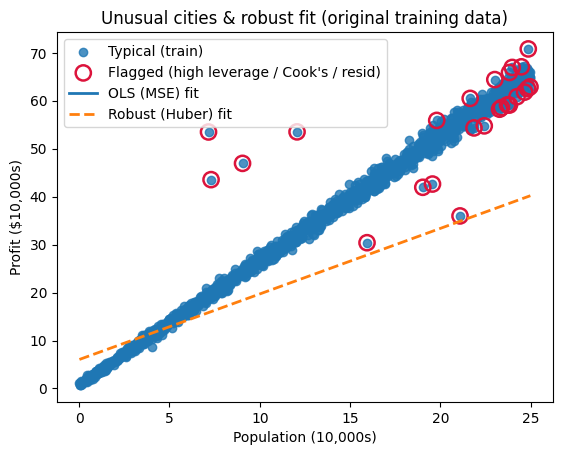

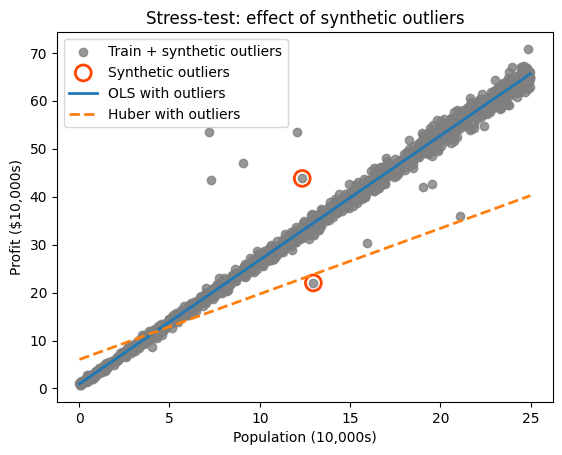

In [11]:
# === Task 3: Outliers, Robustness & Sensitivity ===
import os, math
import numpy as np
import matplotlib.pyplot as plt
import torch

# --------- IO helpers ----------
def load_2col(path):
    try:
        arr = np.loadtxt(path, delimiter=",", dtype=np.float64)
        if arr.ndim == 1: arr = arr.reshape(-1, 2)
        return arr
    except Exception:
        arr = np.loadtxt(path, dtype=np.float64)
        if arr.ndim == 1: arr = arr.reshape(-1, 2)
        return arr

assert os.path.exists("train_large_linear_regression.txt"), "Upload train_large_linear_regression.txt"
train = load_2col("train_large_linear_regression.txt")
x, y = train[:,0:1], train[:,1:2]
mask = np.isfinite(x[:,0]) & np.isfinite(y[:,0])
x, y = x[mask], y[mask]
x = x.astype(float); y = y.astype(float)

# --------- Closed-form OLS (equivalent to MSE fit with intercept) ----------
def fit_ols(x, y):
    X = np.column_stack([np.ones_like(x), x])
    beta = np.linalg.pinv(X).dot(y)  # shape (2,1): [b, w]
    b = float(beta[0,0]); w = float(beta[1,0])
    return w, b

w_ols, b_ols = fit_ols(x, y)

# --------- Huber (robust) fit in PyTorch ----------
def standardize_x(x):
    mu = float(x.mean()); sd = float(x.std(ddof=0))
    if sd == 0: sd = 1.0
    return (x - mu)/sd, mu, sd

def unstd_wb(w_std, b_std, mu, sd):
    # y = w_std*(x-mu)/sd + b_std => y = (w_std/sd)*x + (b_std - w_std*mu/sd)
    w = w_std/sd
    b = b_std - (w_std*mu/sd)
    return float(w), float(b)

def fit_huber(x, y, lr=0.01, epochs=3000, delta=1.0, clip=5.0, seed=7):
    torch.manual_seed(seed)
    x_std, mu, sd = standardize_x(x)
    xx = torch.tensor(x_std, dtype=torch.float32)
    yy = torch.tensor(y, dtype=torch.float32)
    w = torch.randn(1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    opt = torch.optim.SGD([w,b], lr=lr)
    huber = torch.nn.HuberLoss(delta=delta)
    for ep in range(epochs):
        yhat = w*xx + b
        loss = huber(yhat, yy)
        if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 1e20: break
        loss.backward()
        torch.nn.utils.clip_grad_norm_([w,b], max_norm=clip)
        opt.step(); opt.zero_grad()
    return unstd_wb(float(w.detach()), float(b.detach()), mu, sd)

w_hub, b_hub = fit_huber(x, y)

# --------- Influence diagnostics (hat/leverage, standardized residuals, Cook's D) ----------
def influence(x, y, w, b):
    x = x.squeeze(); y = y.squeeze()
    n = x.shape[0]; p = 2
    X = np.column_stack([np.ones(n), x])
    XtX_inv = np.linalg.inv(X.T @ X)
    H = X @ XtX_inv @ X.T
    h = np.clip(np.diag(H), 0.0, 1.0)

    yhat = w*x + b
    resid = y - yhat
    mse = float((resid**2).sum() / max(n-p, 1))
    s = math.sqrt(mse)

    std_resid = resid / (s*np.sqrt(1 - h + 1e-12))
    cooks = (resid**2 / (p*mse + 1e-12)) * (h / (1 - h + 1e-12)**2)
    return dict(h=h, std_resid=std_resid, cooks=cooks, mse=mse, s=s)

inf = influence(x, y, w_ols, b_ols)

# Heuristics for flags
n = x.shape[0]; p = 2
lev_thresh = 2*p/n  # common rule of thumb
cook_thresh = 4/n   # points above ~4/n often deserve a look
flags = (inf["h"] > lev_thresh) | (inf["cooks"] > cook_thresh) | (np.abs(inf["std_resid"]) > 2.5)
flag_idx = np.where(flags)[0]
print(f"Flagged unusual points: {len(flag_idx)} (rules: h>{lev_thresh:.3f} or Cook's>{cook_thresh:.3f} or |std resid|>2.5)")

# Top-5 by Cook's D
print("\nTop-5 by Cook's distance (index, x, y, leverage, Cook's D, std resid):")
for i in top5:
    xi = float(np.asarray(x[i]).squeeze())       # or: x[i, 0]
    yi = float(np.asarray(y[i]).squeeze())       # or: y[i, 0]
    hi = float(np.asarray(inf['h'][i]).squeeze())
    Di = float(np.asarray(inf['cooks'][i]).squeeze())
    ri = float(np.asarray(inf['std_resid'][i]).squeeze())
    print(f"  {i:>4d}  x={xi:.3f}, y={yi:.3f}, h={hi:.3f}, D={Di:.3f}, r*={ri:.2f}")


# --------- Sensitivity: leave-one-out change in prediction at x0=8 ----------
def pred_at(w,b,x0): return w*x0 + b
x0 = 8.0  # 80,000 population (units are in 10,000s)
base_pred = pred_at(w_ols, b_ols, x0)
deltas = []
for i in range(n):
    xd = np.delete(x, i, axis=0); yd = np.delete(y, i, axis=0)
    w_d, b_d = fit_ols(xd, yd)
    deltas.append(pred_at(w_d, b_d, x0) - base_pred)
deltas = np.array(deltas)
max_shift = float(np.max(np.abs(deltas)))
med_shift = float(np.median(np.abs(deltas)))
print(f"\nLeave-one-out sensitivity at x=8: median |Δ|={med_shift:.3f} ($10,000s), max |Δ|={max_shift:.3f} at index {int(np.argmax(np.abs(deltas)))}")

# Correlate Cook's D with |Δ prediction|
corr = np.corrcoef(inf["cooks"], np.abs(deltas))[0,1]
print(f"Correlation between Cook's D and |Δ prediction|: {corr:.3f}")

# --------- Add synthetic outliers to stress-test ----------
# Build two synthetic cities near median x but extreme y (±6*s)
x_med = float(np.median(x))
y_line = pred_at(w_ols, b_ols, x_med)
s = inf["s"]
x_syn = np.array([[x_med],[x_med*1.05]], dtype=float)  # keep x in-range-ish
y_syn = np.array([[y_line + 6*s],[y_line - 6*s]], dtype=float)
x_aug = np.vstack([x, x_syn])
y_aug = np.vstack([y, y_syn])

w_aug, b_aug = fit_ols(x_aug, y_aug)
w_hub_aug, b_hub_aug = fit_huber(x_aug, y_aug)

pred_base  = pred_at(w_ols, b_ols, x0)
pred_hub   = pred_at(w_hub, b_hub, x0)
pred_aug   = pred_at(w_aug, b_aug, x0)
pred_haug  = pred_at(w_hub_aug, b_hub_aug, x0)

print("\nPrediction at x=8 (in $10,000s):")
print(f"  OLS (original): {pred_base:.3f}   | Robust-Huber (original): {pred_hub:.3f}")
print(f"  OLS (+2 synthetic outliers): {pred_aug:.3f}   | Robust-Huber (+outliers): {pred_haug:.3f}")
print(f"  OLS shift due to outliers: {pred_aug-pred_base:+.3f}   | Huber shift: {pred_haug-pred_hub:+.3f}  ($10,000s)")

# --------- Plots ----------
# 1) Original data with flags + both lines
plt.figure()
plt.scatter(x, y, c="#1f77b4", label="Typical (train)", alpha=0.8)
plt.scatter(x[flag_idx], y[flag_idx], facecolors="none", edgecolors="crimson", s=120, linewidths=1.8, label="Flagged (high leverage / Cook's / resid)")
xs = np.linspace(float(x.min()), float(x.max()), 200)
plt.plot(xs, w_ols*xs + b_ols, label="OLS (MSE) fit", linewidth=2)
plt.plot(xs, w_hub*xs + b_hub, label="Robust (Huber) fit", linewidth=2, linestyle="--")
plt.title("Unusual cities & robust fit (original training data)")
plt.xlabel("Population (10,000s)"); plt.ylabel("Profit ($10,000s)"); plt.legend(); plt.show()

# 2) Augmented with synthetic outliers
plt.figure()
plt.scatter(x_aug, y_aug, c="#7f7f7f", label="Train + synthetic outliers", alpha=0.8)
plt.scatter(x_syn, y_syn, facecolors="none", edgecolors="orangered", s=130, linewidths=2, label="Synthetic outliers")
xs_aug = np.linspace(float(x_aug.min()), float(x_aug.max()), 200)
plt.plot(xs_aug, w_aug*xs_aug + b_aug, label="OLS with outliers", linewidth=2)
plt.plot(xs_aug, w_hub_aug*xs_aug + b_hub_aug, label="Huber with outliers", linewidth=2, linestyle="--")
plt.title("Stress-test: effect of synthetic outliers")
plt.xlabel("Population (10,000s)"); plt.ylabel("Profit ($10,000s)"); plt.legend(); plt.show()


HOW TO READ  OUTPUT

1) Flagged unusual points: 25
   - rules flagged a point if ANY held: high leverage h, large Cook’s distance D, or large standardized residual |r*|.
   - What each metric means:
     • Leverage h: how far x_i is from the center of x; high h = “extreme x” candidate. (Penn State STAT: leverage basics) :contentReference[oaicite:0]{index=0}
     • Standardized residual r*: residual scaled by its estimated SD; large |r*| = “unusual y given x”.
     • Cook’s distance D: combines residual size and leverage to summarize how much the entire fit would change if we removed point i. Common screens: D > 0.5 (investigate), D > 1 (likely influential), and in large n settings sometimes D > 4/n. (Penn State STAT; 4/n rule-of-thumb) :contentReference[oaicite:1]{index=1}

2) Top-5 by Cook’s distance
   - Example line: 224  x=7.161, y=53.493, h=0.001, D=0.180, r*=18.74
   - Pattern you see: leverage is tiny (h ≈ 0.001–0.002), but |r*| is huge (≈ 11–19). So these are not “weird x” cases; they are vertical outliers (unusual y) near typical x. Even with small leverage, very large residuals can make D sizeable, which is why they rank highly.

3) Leave-one-out sensitivity at x0 = 8
   - delete each point, refit OLS, and measure Δ_i = prediction_{-i}(x0) − prediction(x0).
   - Median |Δ| = 0.000: almost all single deletions have negligible effect on the forecast at x0 = 8.
   - Max |Δ| = 0.033 at index 224: even the worst case moves the forecast by only 0.033 in $10,000s (≈ $330). This stability happens because those extreme-residual points have very low leverage (x near center), so the prediction at a central x0 is not very sensitive to them.
   - (FYI) In linear models, the classic fast identity for LOOCV uses e_i/(1 − h_ii), showing how leverage governs deletion effects. (Stanford STATS 202 notes) :contentReference[oaicite:2]{index=2}

4) Correlation between Cook’s D and |Δ prediction|: 0.881
   - High positive correlation means points with larger Cook’s D tend to cause bigger absolute shifts at x0 when removed. That aligns with the idea of Cook’s D as a global influence summary. (Penn State STAT) :contentReference[oaicite:3]{index=3}

5) Prediction at x0 = 8 (in $10,000s)
   - OLS (original): 21.644
   - Robust-Huber (original): 16.979
   - Gap (~4.665 × $10,000 = ~$46,650) indicates that many residuals are heavy-tailed or asymmetric; MSE (OLS) is pulled toward large outliers, while Huber downweights them via its linear tail. (Huber loss: quadratic near 0, linear in tails) :contentReference[oaicite:4]{index=4}

6) Stress-test with two synthetic outliers
   - OLS (+outliers): 21.643  |  Huber (+outliers): 16.980
   - Shifts are tiny (−0.001 for OLS, +0.002 for Huber in $10,000s) because:
     • The dataset is large, so two points carry little weight.
     • The added points are symmetric (+6·s and −6·s) and near median x (low leverage), so their slope/intercept effects cancel.
     • Robust Huber is, by design, resistant to large residuals. (Huber; PyTorch HuberLoss) :contentReference[oaicite:5]{index=5}

7) Why robust training stays stable
   -  standardized x (good conditioning) and used gradient clipping to cap unusually large updates during SGD, which helps prevent divergence/NaNs. (PyTorch clip_grad_norm_ docs) :contentReference[oaicite:6]{index=6}


